In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as sim
import scipy.ndimage as sim


import mltools.utils.cuda_tools as cuda_tools
from mltools.networks import networks

device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import models
import importlib
importlib.reload(utils)

plt.rcParams.update({'font.size': 18})

memory_available [17653]
best GPU: 0


In [10]:
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
for fol in glob.glob("../data/images_1/2x2_final2/col_sweep/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/size_sweep/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/detailed/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4_sfixed/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,"plot_data.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
len(plot_datass),c

(20, 100)

In [11]:
def get_i_learned(accs,consistent=3):
    assert consistent%2==1
    #find portion of acc where accs is positive for 3 values
    structure=np.ones(consistent)
    goods=sim.binary_erosion(accs,structure=structure)
    inds=np.nonzero(goods)[0]
    if len(inds)>=1:
        return np.min(inds)
    else:
        return None

In [12]:
sep_cols,sep_sizes=zip(*plot_datass.keys())
sep_cols=np.array(sep_cols)
sep_cols=np.unique(sep_cols)
sep_cols_float=np.array([float(x) for x in sep_cols])
sep_sizes=np.array(sep_sizes)
sep_sizes=np.unique(sep_sizes)
sep_sizes_float=np.array([float(x) for x in sep_sizes])
sep_cols,sep_sizes

(array(['0.1', '0.137', '0.174', '0.211', '0.247', '0.284', '0.321',
        '0.358', '0.395', '0.432', '0.468', '0.505', '0.542', '0.579',
        '0.616', '0.653', '0.689', '0.726', '0.763', '0.8'], dtype='<U5'),
 array(['0.4'], dtype='<U3'))

In [13]:
import scipy.ndimage as sim
t_cols_tr=np.full((len(sep_cols),len(sep_sizes)),np.nan)
t_cols=np.full((len(sep_cols),len(sep_sizes)),np.nan)
t_sizes_tr=np.full((len(sep_cols),len(sep_sizes)),np.nan)
t_sizes=np.full((len(sep_cols),len(sep_sizes)),np.nan)
rightss_trs=[]
rightss_tes=[]
for key,plot_datas in plot_datass.items():
    sep_col=key[0]
    sep_size=key[1]
    i_sep_col=np.where(sep_cols==sep_col)[0][0]
    i_sep_size=np.where(sep_sizes==sep_size)[0][0]

    rightss_tr=[]
    rightss_te=[]
    for i in range(len(plot_datas)):
        plot_data=plot_datas[i]
        save_steps=plot_data["save_steps"]
        #rights_tr=plot_data["rightprobss_tr"]
        #rights_te=plot_data["rightprobss_te"]
        rights_tr=plot_data["rights_tr"]
        rights_te=plot_data["rights_te"]
        rightss_tr.append(rights_tr)
        rightss_te.append(rights_te)
    rightss_trs.append(rightss_tr)
    rightss_tes.append(rightss_te)
    rightss_tr=np.stack(rightss_tr,axis=0)
    rightss_te=np.stack(rightss_te,axis=0)
    rightss_te=rightss_te.astype(np.float32)
    accs_tr_m=rightss_tr.mean(2)
    accs_m=rightss_te.mean(2)
    accs_tr_smoothed=sim.gaussian_filter1d(accs_tr_m,1.5,axis=1)
    accs_smoothed=sim.gaussian_filter1d(accs_m,1.5,axis=1)
    thres=0.9
    save_steps=plot_datas[0]["save_steps"]
    i_learned_cols_tr=[get_i_learned(acc_smoothed[:,0]>thres,consistent=3) for acc_smoothed in accs_tr_smoothed]
    i_learned_cols=[get_i_learned(acc_smoothed[:,0]>thres,consistent=3) for acc_smoothed in accs_smoothed]
    i_learned_sizes_tr=[get_i_learned(acc_smoothed[:,1]>thres,consistent=3) for acc_smoothed in accs_tr_smoothed]
    i_learned_sizes=[get_i_learned(acc_smoothed[:,1]>thres,consistent=3) for acc_smoothed in accs_smoothed]
    step_learned_cols_tr=[20000 if el is None else save_steps[el] for el in i_learned_cols_tr]
    step_learned_cols=[20000 if el is None else save_steps[el] for el in i_learned_cols]
    step_learned_sizes_tr=[20000 if el is None else save_steps[el] for el in i_learned_sizes_tr]
    step_learned_sizes=[20000 if el is None else save_steps[el] for el in i_learned_sizes]
    t_cols_tr[i_sep_col,i_sep_size]=np.mean(step_learned_cols_tr)
    t_cols[i_sep_col,i_sep_size]=np.mean(step_learned_cols)
    t_sizes_tr[i_sep_col,i_sep_size]=np.mean(step_learned_sizes_tr)
    t_sizes[i_sep_col,i_sep_size]=np.mean(step_learned_sizes)
rightss_trs=np.stack(rightss_trs,axis=0)
rightss_tes=np.stack(rightss_tes,axis=0)
None

In [14]:
_,_,l_tr,_,_,l_te=utils.generate_data(utils.load_config(glob.glob(os.path.join(fol,"*.yaml"))[0]),forgen=True)

In [15]:
#np.save("../data/to_maya/sep7xsep7/accuracies/save_steps.npy",save_steps)
#np.save("../data/to_maya/sep7xsep7/accuracies/rightss_trs.npy",rightss_trs)
#np.save("../data/to_maya/sep7xsep7/accuracies/rightss_tes.npy",rightss_tes)
#np.save("../data/to_maya/sep7xsep7/accuracies/sep_cols_float.npy",sep_cols_float)
#np.save("../data/to_maya/sep7xsep7/accuracies/sep_sizes_float.npy",sep_sizes_float)
#np.save("../data/to_maya/sep7xsep7/accuracies/l_tr.npy",l_tr)
#np.save("../data/to_maya/sep7xsep7/accuracies/l_te.npy",l_te)

In [16]:
rightss_tes.shape

(20, 5, 60, 32, 2)

Text(0.5, 0, '$\\Delta$ Size')

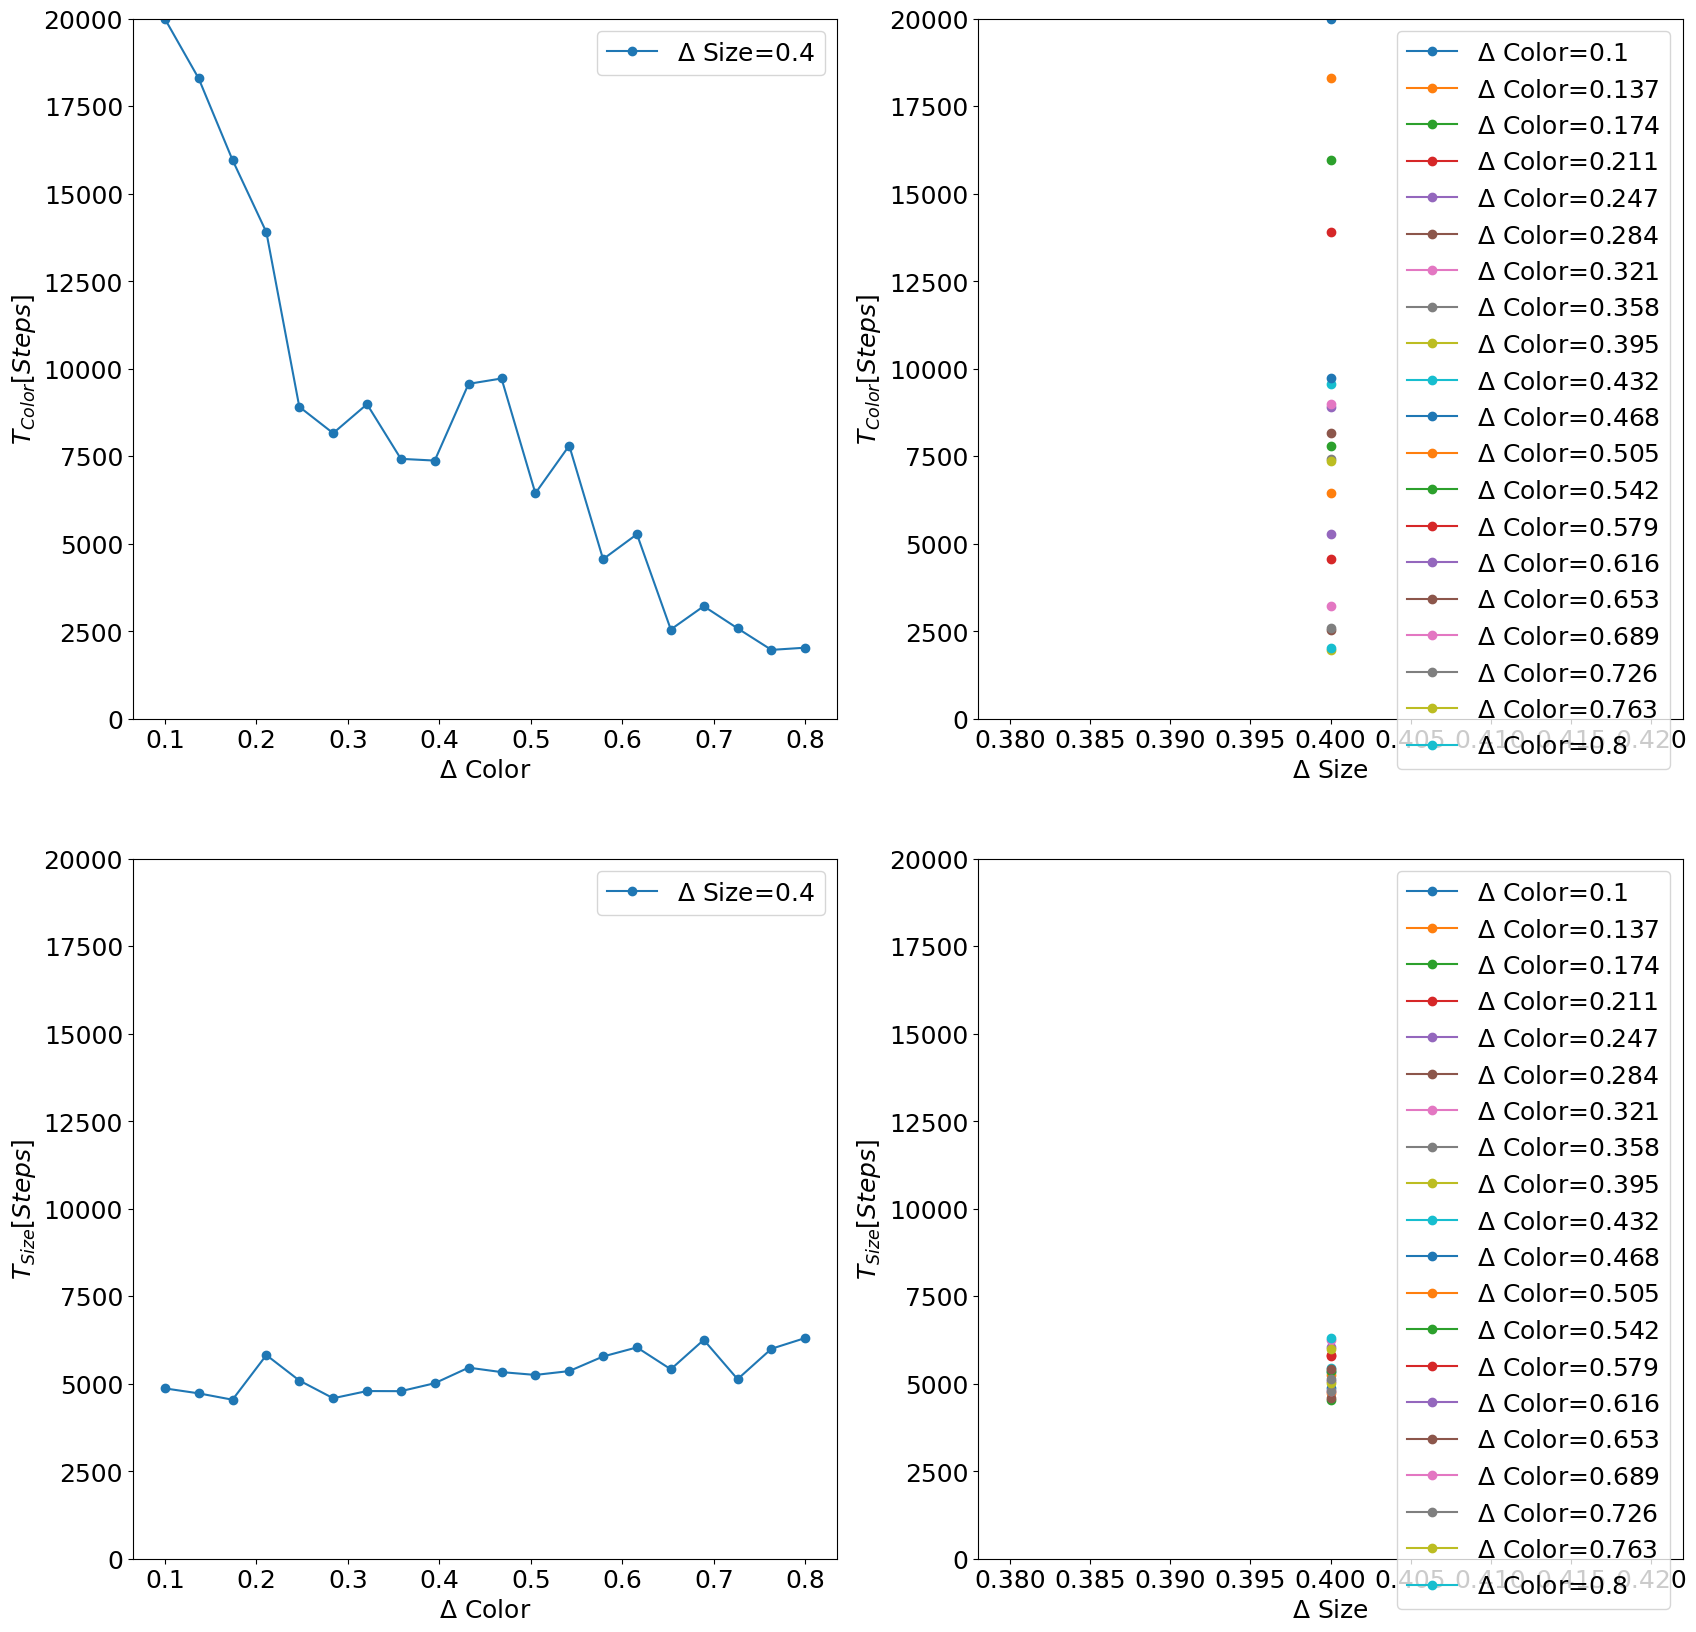

In [17]:
y_top=20000

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
for i in range(len(sep_sizes)):
    plt.plot(sep_cols_float,t_cols[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o")
    #plt.fill_between(sep_cols_float,t_cols[:,i]-t_cols_s[:,i],t_cols[:,i]+t_cols_s[:,i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Color} [Steps]$")
plt.xlabel(r"$\Delta$ Color")
plt.subplot(2,2,2)
for i in range(len(sep_cols)):
    plt.plot(sep_sizes_float,t_cols[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o")
    #plt.fill_between(sep_sizes_float,t_cols[i]-t_cols_s[i],t_cols[i]+t_cols_s[i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Color} [Steps]$")
plt.xlabel(r"$\Delta$ Size")

plt.subplot(2,2,3)
for i in range(len(sep_sizes)):
    plt.plot(sep_cols_float,t_sizes[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o")
    #plt.fill_between(sep_cols_float,t_sizes[:,i]-t_sizes_s[:,i],t_sizes[:,i]+t_sizes_s[:,i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Size} [Steps]$")
plt.xlabel(r"$\Delta$ Color")
plt.subplot(2,2,4)
for i in range(len(sep_cols)):
    plt.plot(sep_sizes_float,t_sizes[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o")
    #plt.fill_between(sep_sizes_float,t_sizes[i]-t_sizes_s[i],t_sizes[i]+t_sizes_s[i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Size} [Steps]$")
plt.xlabel(r"$\Delta$ Size")
#plt.savefig("../figures/final/learning_times.png")

In [18]:
sep_cols_float

array([0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
       0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ])

Text(0.5, 0, '$\\Delta$ Size')

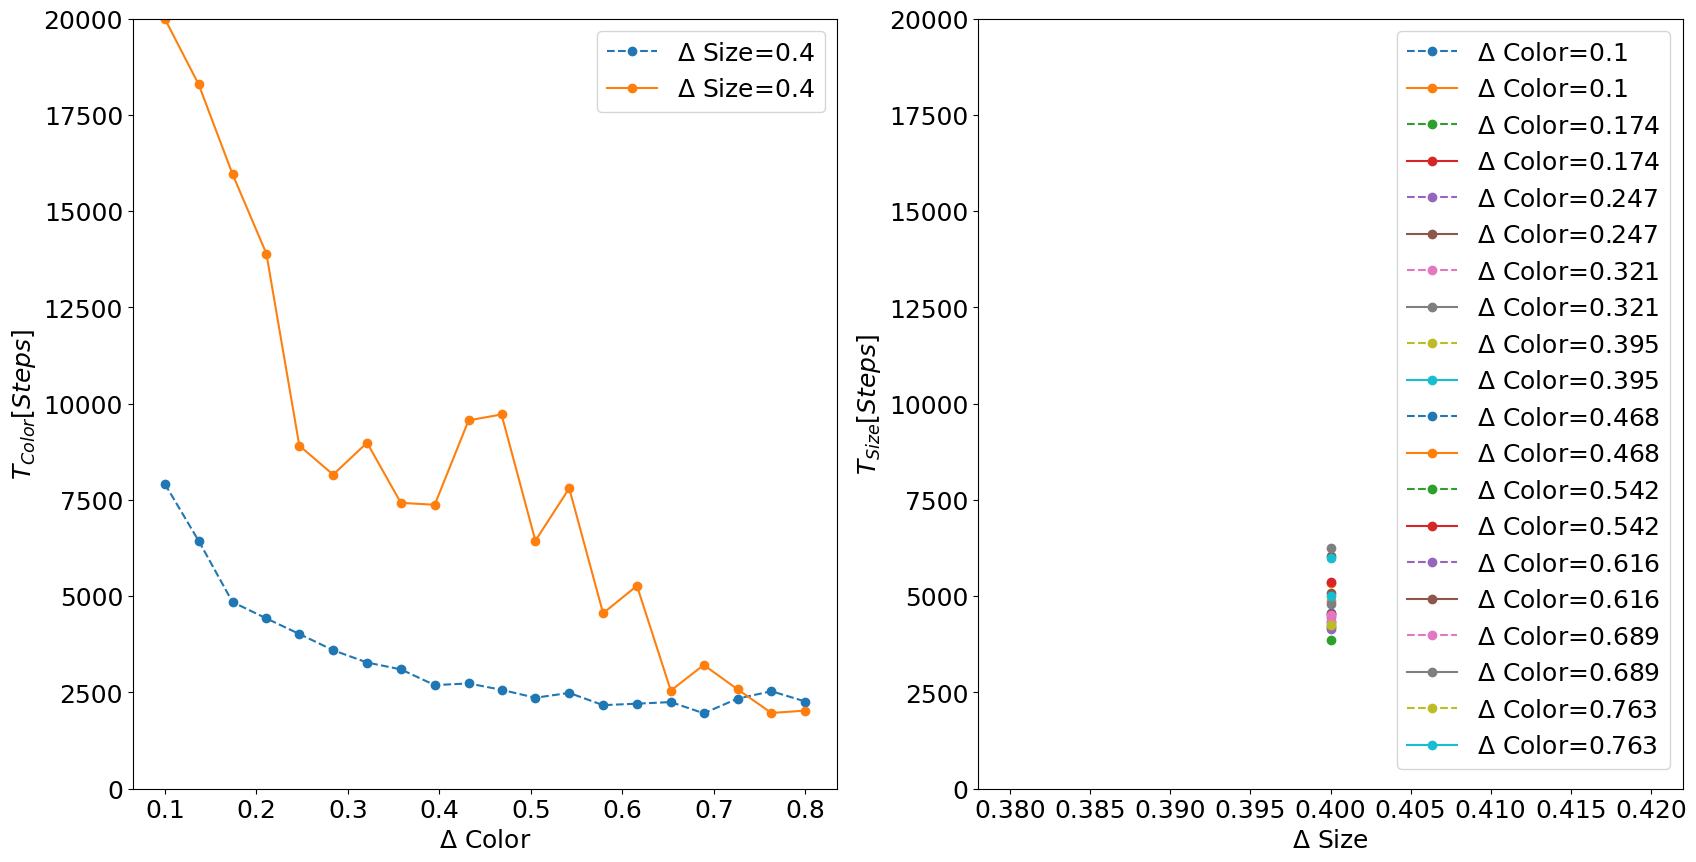

In [19]:
y_top=20000

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
for i in range(0,len(sep_sizes),2):
    plt.plot(sep_cols_float,t_cols_tr[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o",ls="--")
    plt.plot(sep_cols_float,t_cols[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o")
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Color} [Steps]$")
plt.xlabel(r"$\Delta$ Color")

plt.subplot(1,2,2)
for i in range(0,len(sep_cols),2):
    plt.plot(sep_sizes_float,t_sizes_tr[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o",ls="--")
    plt.plot(sep_sizes_float,t_sizes[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o")
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Size} [Steps]$")
plt.xlabel(r"$\Delta$ Size")
#plt.savefig("../figures/final/learning_times.png")

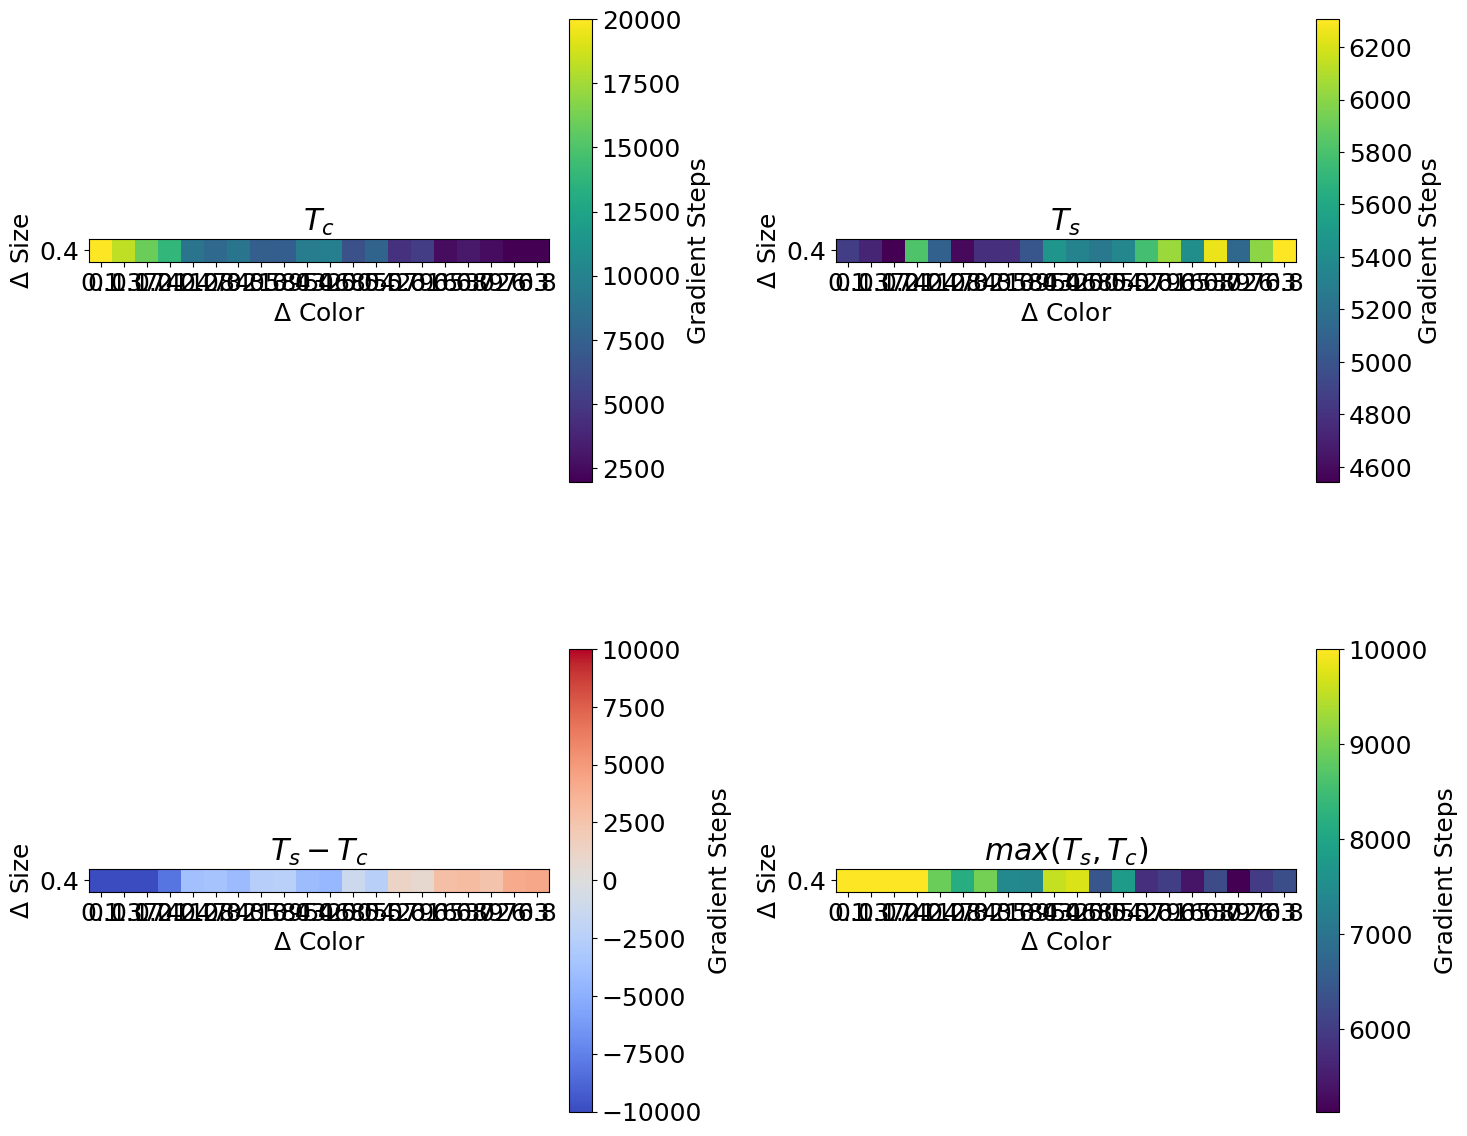

In [20]:
plt.figure(figsize=(15,13))
plt.subplot(2,2,1)
plt.imshow(t_cols.transpose(1,0),interpolation="none",origin="lower")
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$T_c$")

plt.subplot(2,2,2)
plt.imshow(t_sizes.transpose(1,0),interpolation="none",origin="lower")
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$T_s$")
plt.subplot(2,2,3)
plt.imshow((t_sizes-t_cols).transpose(1,0),interpolation="none",origin="lower",cmap="coolwarm",vmin=-10000,vmax=10000)
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$T_s-T_c$")
plt.subplot(2,2,4)
plt.imshow(np.maximum(t_sizes,t_cols).transpose(1,0),interpolation="none",origin="lower",vmax=10000)
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
cb=plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$max(T_s,T_c)$")
plt.tight_layout()
#plt.savefig("../figures/final/learning_times_2d.png")


In [21]:
#_=plt.scatter((t_sizes-t_cols),np.maximum(t_sizes,t_cols),s=10)
#plt.xlabel(r"$T_s-T_c$")

In [23]:
suffix="_w_cfg_3.0"
suffix=""
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/sep_col=0.2_sep_size=0.3/seed=4*"):
#for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt3/sep_col=0.2_sep_size=0.3/*"):
for fol in glob.glob("../data/images_1/2x2_final2/col_sweep/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep_gamma1/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep_inis=0.1/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep_wd=0.05/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep_det/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep_cfg_long3/*/seed=*"):
    seed=int(fol.split("seed=")[1])
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,f"plot_data{suffix}.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["seed"]=seed
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(20, 100)

In [24]:
plot_datass.keys()

dict_keys([('0.284', '0.4'), ('0.358', '0.4'), ('0.432', '0.4'), ('0.653', '0.4'), ('0.321', '0.4'), ('0.1', '0.4'), ('0.763', '0.4'), ('0.395', '0.4'), ('0.211', '0.4'), ('0.579', '0.4'), ('0.726', '0.4'), ('0.505', '0.4'), ('0.8', '0.4'), ('0.468', '0.4'), ('0.689', '0.4'), ('0.542', '0.4'), ('0.137', '0.4'), ('0.247', '0.4'), ('0.616', '0.4'), ('0.174', '0.4')])

In [25]:
config=utils.load_config('../data/images_1/2x2_final2/col_sweep/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml')
#config=utils.load_config('../data/images_1/2x2_final2/col_sweep_inis=0.1/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml')
#config=utils.load_config('../data/images_1/2x2_final2/col_sweep_wd=0.05/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)
plot_datas=plot_datass[list(plot_datass.keys())[0]]
save_steps=plot_datas[0]["save_steps"]

In [26]:
cmap="gnuplot"
cmap="rainbow"
norm = mcolors.Normalize(vmin=0.1, vmax=0.8)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

In [32]:
np.sort(sep_cols),np.sort(sep_sizes)

(array([0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
        0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
        0.763, 0.8  ]),
 array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]))

In [50]:
#sel=["0.1","0.174","0.247","0.321","0.395","0.468","0.542","0.616","0.689","0.763","0.8"]
sel=["0.137","0.247","0.395","0.542","0.689","0.8"]
sel=["0.137","0.247","0.689"]
sel=["0.137","0.174"]
sel=["0.174"]

min step 1331
star step 3933


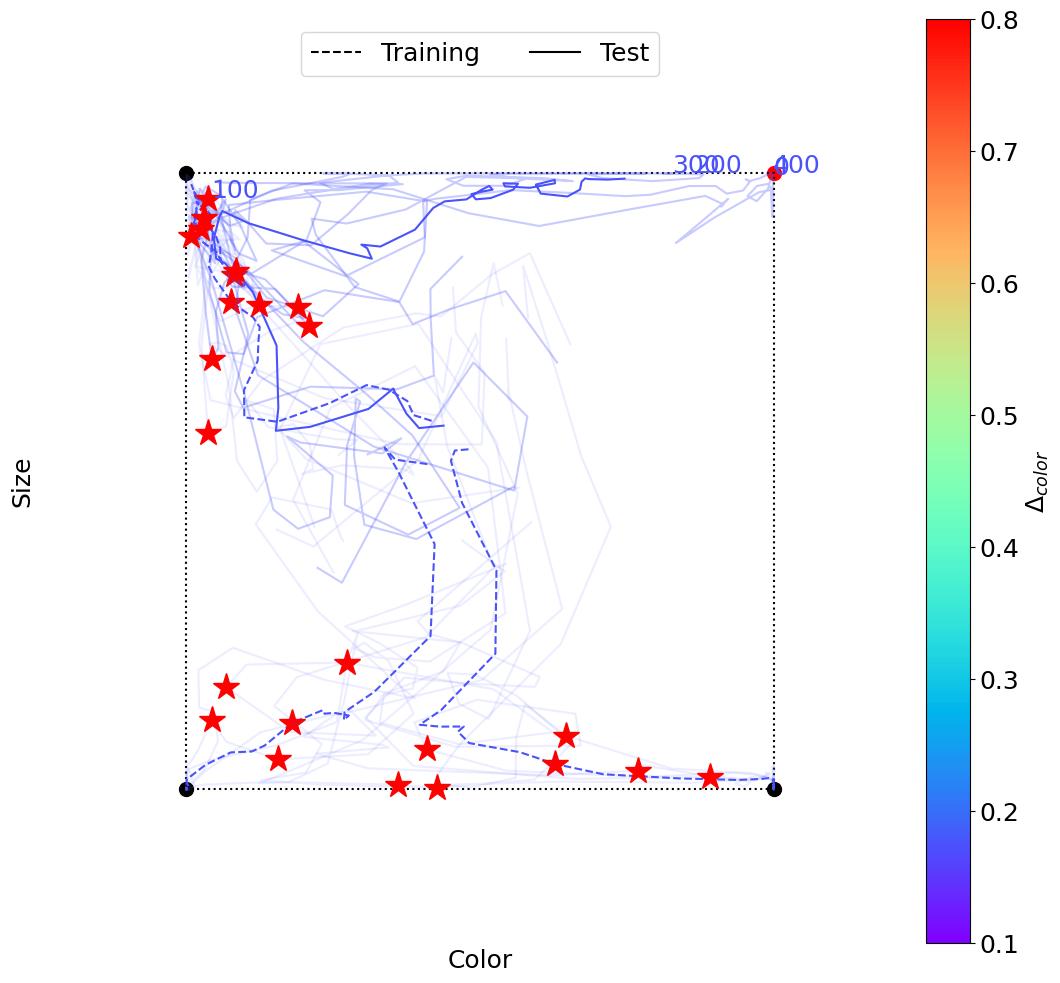

In [54]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

i_step_min=7
print("min step",save_steps[i_step_min])

sigma_smooth=1.0

plot_mean=True

plot_train=True

plot_star=True
i_star=20
print("star step",save_steps[i_star])

plot_singles=True
#single_seeds=[4]
single_seeds=[0,100,200,300,400]

trajs_trss=[]
trajs_tess=[]
trajs_tesss=[]
sep_cols=[]
sep_sizes=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    #cfg=float(key[2])
    sep_cols.append(float(sep_col))
    sep_sizes.append(float(sep_size))
    #if  sep_col!="0.2" or sep_size!="0.3":
    #    continue
    if sep_col not in sel:
        continue
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    seeds=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
        seeds.append(plot_data["seed"])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_tesss.append(classprobs_pred_tes[:,:,:,l_te==3].mean(3))
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,sigma_smooth,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,sigma_smooth,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)
    #color=cfg_to_color(cfg,cmap=cmap)

    if plot_mean:
        plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],c=color,markersize=5)
        if plot_train:
            for i in range(3):
                plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
        if plot_star:
            plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
            if plot_train:
                for i in range(3):
                    plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)

    if plot_singles:
        for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
            seed=seeds[i_seed]
            if seed not in single_seeds:
                continue
            traj_smooth=sim.gaussian_filter1d(traj_te_single,sigma_smooth,axis=0,truncate=6.0)
            plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.3)
            plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        if plot_train:
            for i in range(3):
                for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                    seed=seeds[i_seed]
                    if seed not in single_seeds:
                        continue
                    traj_smooth=sim.gaussian_filter1d(traj_tr_single,sigma_smooth,axis=0,truncate=6.0)
                    plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
                    #plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        if plot_star:
            for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
                seed=seeds[i_seed]
                if seed not in single_seeds:
                    continue
                traj_smooth=sim.gaussian_filter1d(traj_te_single,sigma_smooth,axis=0,truncate=6.0)
                plt.plot(traj_smooth[i_star,0],traj_smooth[i_star,1],marker="*",c="r",markersize=20)
            if plot_train:
                for i in range(3):
                    for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                        seed=seeds[i_seed]
                        if seed not in single_seeds:
                            continue
                        traj_smooth=sim.gaussian_filter1d(traj_tr_single,sigma_smooth,axis=0,truncate=6.0)
                        plt.plot(traj_smooth[i_star,0],traj_smooth[i_star,1],marker="*",c="r",markersize=20)
trajs_tesss=np.stack(trajs_tesss,axis=0)
trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
sep_cols=np.array(sep_cols)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_cfg)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta_{color}$")
#cbar.set_label(r"$w_{cfg}$")

In [55]:
trajs_tesss.shape

(1, 5, 60, 2)

(0.0, 1.0)

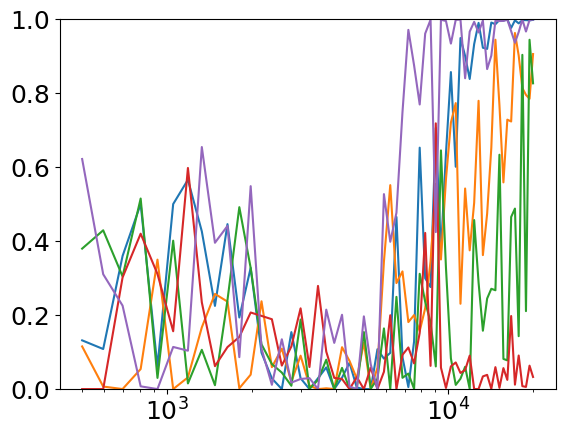

In [56]:
for i in range(5):
    plt.plot(save_steps,trajs_tesss[0,i].prod(-1))
plt.xscale("log")
plt.ylim(0,1)

In [59]:
save_steps1=(np.linspace(np.sqrt(50),np.sqrt(3999),20)**2).astype(int).tolist()
save_steps2=np.linspace(4000,20000,200).astype(int).tolist()
save_steps3=(np.linspace(np.sqrt(20001),np.sqrt(40000),20)**2).astype(int).tolist()
save_steps=save_steps1+save_steps2+save_steps3
np.array(save_steps),len(save_steps)

(array([   50,   100,   168,   254,   357,   477,   615,   770,   943,
         1134,  1341,  1567,  1810,  2070,  2348,  2643,  2956,  3286,
         3633,  3999,  4000,  4080,  4160,  4241,  4321,  4402,  4482,
         4562,  4643,  4723,  4804,  4884,  4964,  5045,  5125,  5206,
         5286,  5366,  5447,  5527,  5608,  5688,  5768,  5849,  5929,
         6010,  6090,  6170,  6251,  6331,  6412,  6492,  6572,  6653,
         6733,  6814,  6894,  6974,  7055,  7135,  7216,  7296,  7376,
         7457,  7537,  7618,  7698,  7778,  7859,  7939,  8020,  8100,
         8180,  8261,  8341,  8422,  8502,  8582,  8663,  8743,  8824,
         8904,  8984,  9065,  9145,  9226,  9306,  9386,  9467,  9547,
         9628,  9708,  9788,  9869,  9949, 10030, 10110, 10190, 10271,
        10351, 10432, 10512, 10592, 10673, 10753, 10834, 10914, 10994,
        11075, 11155, 11236, 11316, 11396, 11477, 11557, 11638, 11718,
        11798, 11879, 11959, 12040, 12120, 12201, 12281, 12361, 12442,
      

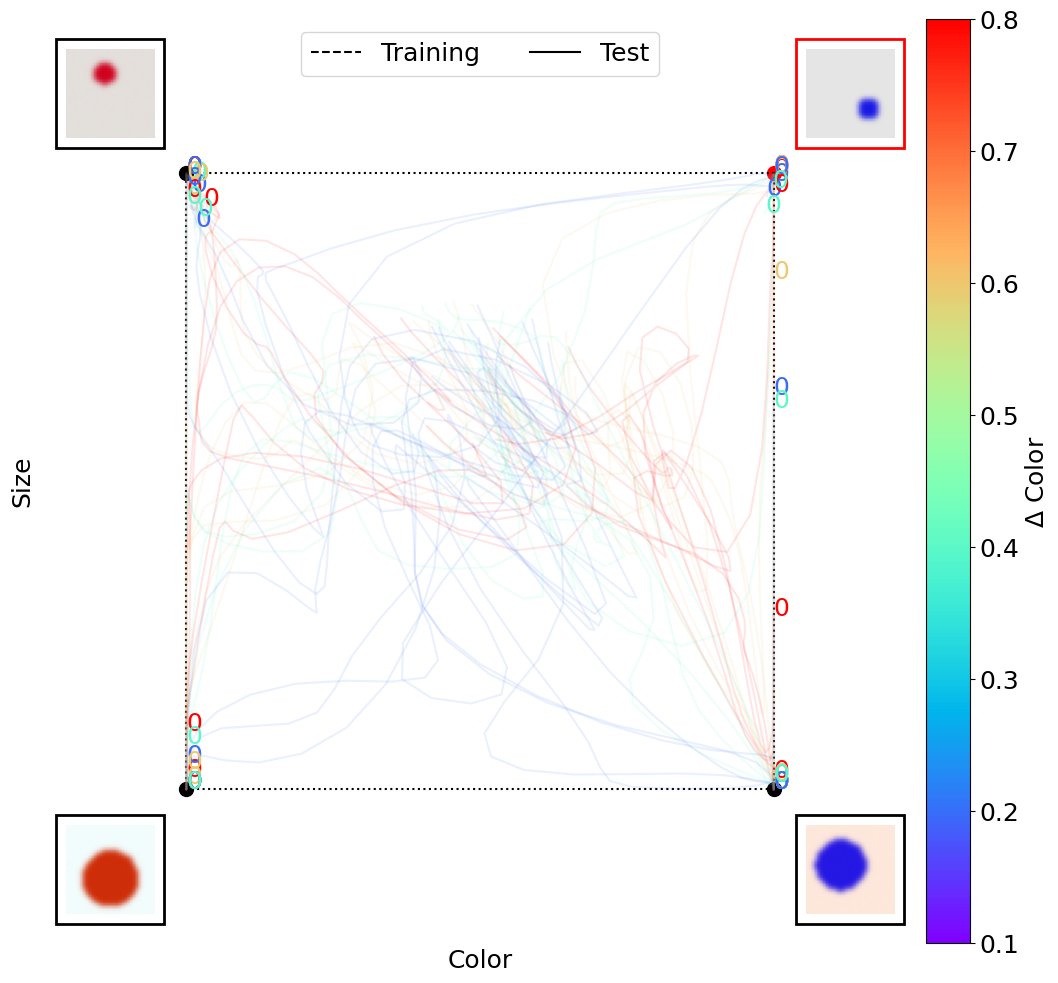

In [89]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

plot_star=False
plot_singles=True
plot_mean=False
single_seeds=[0,100,200,300,400]

trajs_trss=[]
trajs_tess=[]
sep_cols=[]
sep_sizes=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    sep_cols.append(float(sep_col))
    sep_sizes.append(float(sep_size))
    #if sep_col not in sel:
    #    continue
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    seeds=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
        seeds.append(plot_data["seed"])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)

    if plot_mean:
        plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
        for i in range(3):
            plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)

    if plot_singles:
        for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
            seed=seeds[i_seed]
            if seed not in single_seeds:
                continue
            traj_smooth=sim.gaussian_filter1d(traj_te_single,2.0,axis=0,truncate=6.0)
            plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
            plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        for i in range(3):
            for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                seed=seeds[i_seed]
                if seed not in single_seeds:
                    continue
                traj_smooth=sim.gaussian_filter1d(traj_tr_single,2.0,axis=0,truncate=6.0)
                plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
                plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
    if plot_star:
        print("star step",save_steps[i_star])
        i_star=20
        plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
        for i in range(3):
            plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)

trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
sep_cols=np.array(sep_cols)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
images=[]
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    images.append(image)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)
images=np.stack(images,axis=0)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Color")
#plt.savefig("../figures/final/training_dynamics_sep_col_wd=0.05.png")

In [142]:
"""
save_dict={"trajs_trss":trajs_trss,
"trajs_tess":trajs_tess,
"sep_cols":sep_cols,
"images":images}
torch.save(save_dict,"./trajs.pth")
"""

In [143]:
#single

In [144]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
save_steps=plot_datas[0]["save_steps"]
save_steps[i_step_min]

500

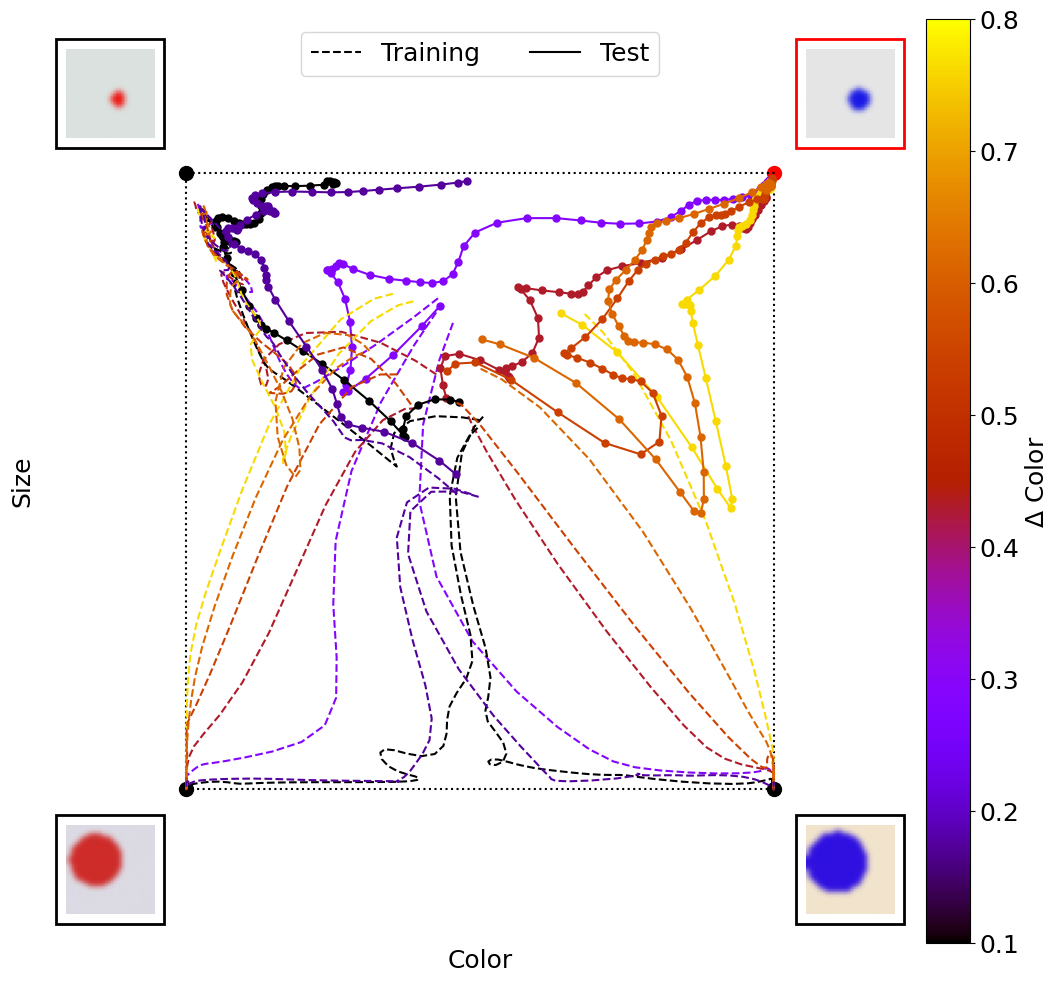

In [7]:
fig=plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
trajs_trss=[]
trajs_tess=[]
sep_cols=[]
for key in plot_datass.keys():
    sep_col=key[0]
    if sep_col not in ["0.1","0.174","0.284","0.432","0.542","0.616","0.763"]:#"0.211":#"0.763":#"0.211":#"0.763":#0.763
        continue
    sep_cols.append(float(sep_col))
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))#.mean(3))#
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))#.mean(3)#

    #trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=2,truncate=6.0)
    #trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=1,truncate=6.0)
    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)
    i_star=10
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",markersize=5,c=color)
    #plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
        #plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)
    """
    for b in range(len(trajs_te)):
        plt.plot(trajs_te[b,i_step_min:,0],trajs_te[b,i_step_min:,1],marker="o",markersize=5)
        plt.plot(trajs_te[b,i_star,0],trajs_te[b,i_star,1],marker="*",c="r",markersize=20)
        #for i in range(3):
        #    plt.plot(trajs_trs[i,b,i_step_min:,0],trajs_trs[i,b,i_step_min:,1],ls="--",c=color)
        #    plt.plot(trajs_trs[i,b,i_star,0],trajs_trs[i,b,i_star,1],marker="*",c="r",markersize=20)
    """
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Color")
#plt.savefig("../figures/final/training_dynamics_sep_col_wd=0.05.png")

In [183]:
import copy

In [184]:
import matplotlib.animation as animation
fig_=copy.deepcopy(fig)
ax=fig_.get_axes()[0]
i_star=0
plots=[]
for trajs_te in trajs_tess:
    plots.extend(ax.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20))
for trajs_trs in trajs_trss:
    for i in range(3):
        plots.extend(ax.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20))

def update(step):
    c=0
    for i in range(len(trajs_tess)):
        plots[i].set_data(trajs_tess[i][step,0],trajs_tess[i][step,1])
        c+=1
    for i in range(len(trajs_trss)):
        for j in range(3):
            plots[c+3*i+j].set_data(trajs_trss[i][j,step,0],trajs_trss[i][j,step,1])
    return plots

ani = animation.FuncAnimation(fig_, update, frames=range(0,60), blit=True)
ani.save("../figures/final/training_dynamics.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_2993907/767120046.py:15: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plots[i].set_data(trajs_tess[i][step,0],trajs_tess[i][step,1])
/tmp/ipykernel_2993907/767120046.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plots[c+3*i+j].set_data(trajs_trss[i][j,step,0],trajs_trss[i][j,step,1])


In [ ]:

i_star=10
ax.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
for i in range(3):
    fig_.gca().plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)
fig_

In [ ]:

i_star=10
plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
for i in range(3):
    plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)

In [52]:
sep_cols=np.array(sep_cols)

In [46]:
trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
displacement_trss=np.linalg.norm(np.gradient(trajs_trss,save_steps,axis=2),axis=3)
displacement_tess=np.linalg.norm(np.gradient(trajs_tess,save_steps,axis=1),axis=2)

(20, 3, 60, 2)

In [88]:
displacement_trss_m=displacement_trss.mean((0,1))
displacement_trss_s=displacement_trss.std((0,1),ddof=1)
displacement_trss_cm=displacement_trss.mean(1)
log_displacement_trss_cm=np.log(displacement_trss_cm)

displacement_tess_m=displacement_tess.mean(0)
displacement_tess_s=displacement_tess.std(0,ddof=1)
displacement_tess_cm=displacement_tess
log_displacement_tess_cm=np.log(displacement_tess_cm)

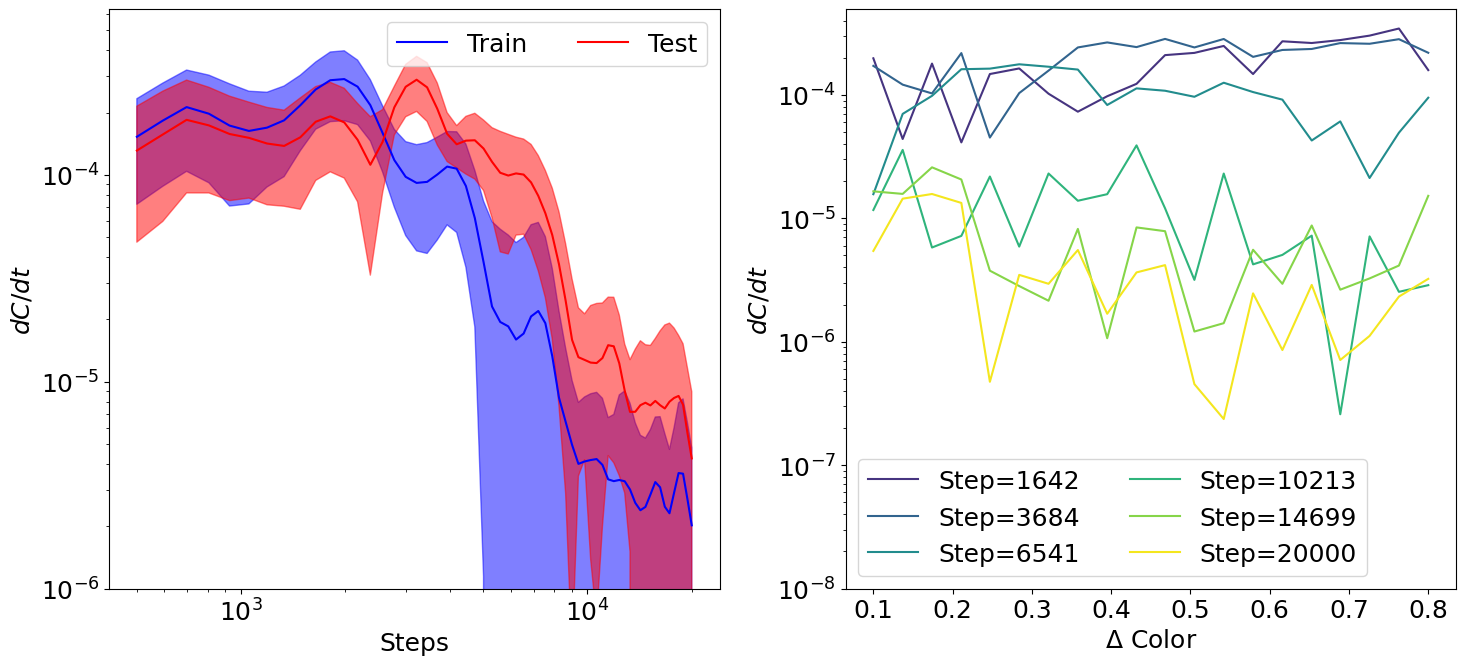

In [117]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(save_steps,displacement_trss_m,c="b",label="Train")
plt.fill_between(save_steps,displacement_trss_m-displacement_trss_s,displacement_trss_m+displacement_trss_s,alpha=0.5,color="b")
plt.plot(save_steps,displacement_tess_m,c="r",label="Test")
plt.fill_between(save_steps,displacement_tess_m-displacement_tess_s,displacement_tess_m+displacement_tess_s,alpha=0.5,color="r")
plt.yscale("log")
plt.xscale("log")
plt.ylim(bottom=1e-6)
plt.ylabel(r"$dC/dt$")
plt.xlabel("Steps")
plt.legend(ncol=2)

plt.subplot(1,2,2)
for i in [9,19,29,39,49,59]:
    indsort=np.argsort(sep_cols)
    step=save_steps[i]
    #_=plt.plot(sep_cols[indsort],displacement_trss_cm[:,i][indsort],c=matplotlib.colormaps["viridis"](i/60),ls="--",alpha=0.5)
    _=plt.plot(sep_cols[indsort],displacement_tess_cm[:,i][indsort],c=matplotlib.colormaps["viridis"](i/60),label=f"Step={step}")
plt.yscale("log")
plt.ylim(bottom=1e-8)
plt.ylabel(r"$dC/dt$")
plt.xlabel(r"$\Delta$ Color")
plt.legend(ncol=2)

plt.tight_layout()
#plt.savefig("../figures/final/dCdt.png")

In [80]:
log_steps=np.log(save_steps)

In [99]:
#variance explained from the two dimensions
import sklearn.linear_model as sklin
import sklearn.metrics as skmet
x_sep_cols=sep_cols[:,None].repeat(60,axis=1).reshape(-1,1)
x_log_steps=log_steps[None,:].repeat(20,axis=0).reshape(-1,1)
x_joint=np.concatenate([x_sep_cols,x_log_steps],axis=1)
y=log_displacement_trss_cm.reshape(-1,1)

linreg_sep_cols=sklin.LinearRegression()
linreg_sep_cols.fit(x_sep_cols,y)
r2_sep_cols=skmet.r2_score(y,linreg_sep_cols.predict(x_sep_cols))

linreg_log_steps=sklin.LinearRegression()
linreg_log_steps.fit(x_log_steps,y)
r2_log_steps=skmet.r2_score(y,linreg_log_steps.predict(x_log_steps))

linreg_joint=sklin.LinearRegression()
linreg_joint.fit(x_joint,y)
r2_joint=skmet.r2_score(y,linreg_joint.predict(x_joint))

r2_sep_cols,r2_log_steps,r2_joint

(0.010445819627637465, 0.7922229880231804, 0.8026688060810088)

In [48]:
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
for fol in glob.glob("../data/images_1/2x2_final2/size_sweep/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,"plot_data.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(20, 75)

In [49]:
fol

'../data/images_1/2x2_final2/size_sweep/sep_col=0.4_sep_size=0.316/seed=0'

In [50]:
config=utils.load_config('../data/images_1/2x2_final2/size_sweep/sep_col=0.4_sep_size=0.389/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [55]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
plot_datas[0]["save_steps"][i_step_min]

594

In [56]:
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap="cubehelix"
norm = mcolors.Normalize(vmin=0.2, vmax=0.389)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

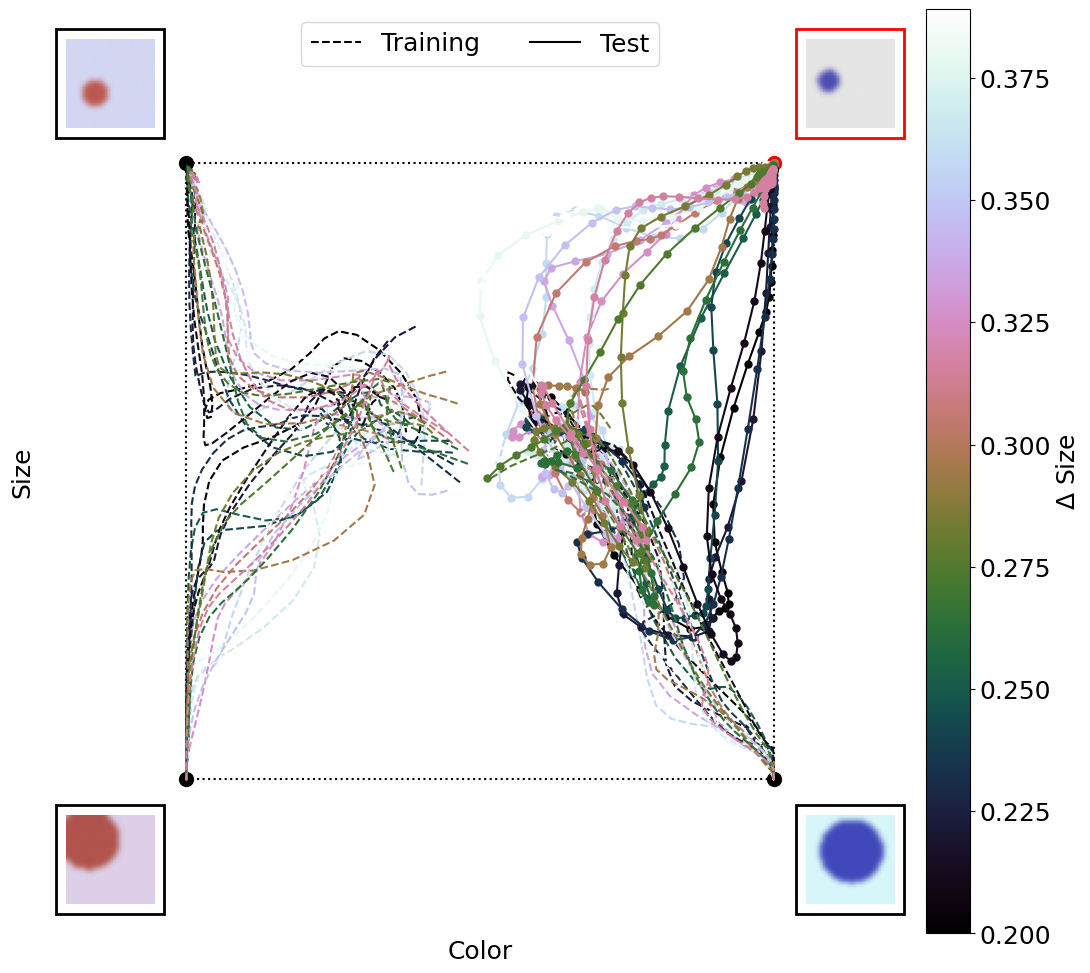

In [57]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
for key in plot_datass.keys():
    sep_size=key[1]
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0)
    color=sep_col_to_color(sep_size,cmap=cmap)
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Size")
plt.savefig("../figures/final/training_dynamics_sep_size.png")

In [135]:
plot_datass={}
c=0
for fol in glob.glob("../data/images_1/2x2_final2/detailed/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    if (sep_col,sep_size) not in [("0.4","0.333"),("0.8","0.333"),("0.2","0.333"),("0.4","0.2"),("0.4","0.4")]:
        continue

    plot_data_file=os.path.join(fol,"plot_data.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(5, 25)

In [136]:
config=utils.load_config('../data/images_1/2x2_final2/detailed/sep_col=0.4_sep_size=0.333/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [137]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
plot_datas[0]["save_steps"][i_step_min]

10

In [138]:
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap="gnuplot"
norm = mcolors.Normalize(vmin=0.2, vmax=0.389)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

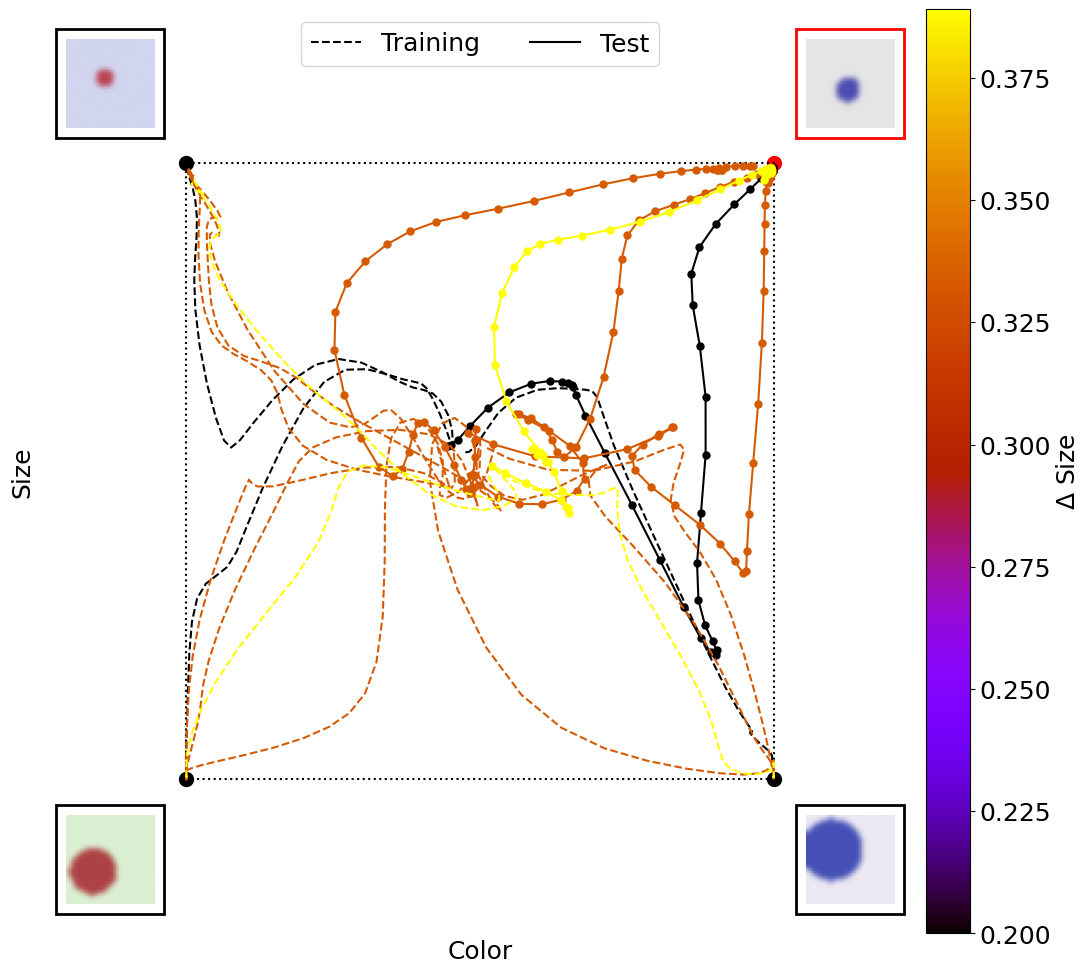

In [139]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
for key in plot_datass.keys():
    sep_size=key[1]
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0)
    color=sep_col_to_color(sep_size,cmap=cmap)
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Size")
plt.savefig("../figures/final/training_dynamics_scss.png")

ckpt stuff

In [ ]:
plot_datass={}
c=0
for fol in glob.glob("../data/images_1/2x2_final2/"):
    pass

In [60]:
ckpts=plot_datas[0]["ckpts"]
ckpt_keys=ckpts[0].keys()
tckpt={}
for key in ckpt_keys:
    if "model.score_model" not in key:
        continue
    key_=key.replace("model.score_model.","")
    tckpt[key_]=[]
    for ckpt in ckpts:
        tckpt[key_].append(ckpt[key])  
    tckpt[key_]=torch.stack(tckpt[key_],axis=0).cpu().numpy()
    print(key_,tckpt[key_].shape)

embed_t_conditioning.0.weight (60, 256, 64)
embed_t_conditioning.0.bias (60, 256)
embed_t_conditioning.2.weight (60, 256, 256)
embed_t_conditioning.2.bias (60, 256)
embedders.0.0.0.weight (60, 1024, 256)
embedders.0.0.0.bias (60, 1024)
embedders.0.0.2.weight (60, 1024, 1024)
embedders.0.0.2.bias (60, 1024)
embedders.0.1.0.weight (60, 1024, 2)
embedders.0.1.0.bias (60, 1024)
embedders.0.1.2.weight (60, 1024, 1024)
embedders.0.1.2.bias (60, 1024)
layers.0.weight (60, 1024, 2)
layers.0.bias (60, 1024)
layers.1.weight (60, 2, 1024)
layers.1.bias (60, 2)


In [61]:
tckpt['embedders.0.1.2.weight'].shape

(60, 1024, 1024)

In [62]:
eigvs=np.linalg.eigvals(tckpt['embedders.0.1.2.weight'])
eigvs.shape

(60, 1024)

In [63]:
eigvs_abs=np.abs(eigvs)**2

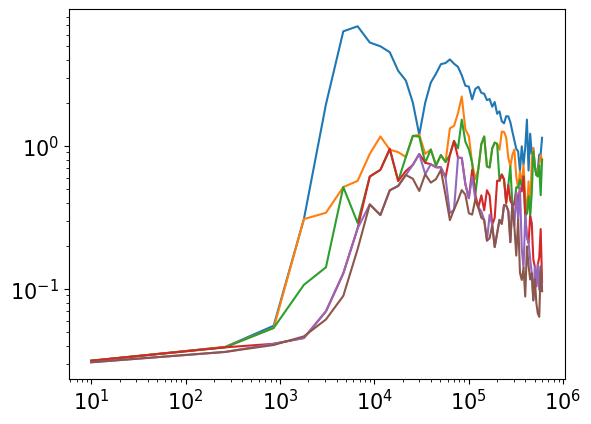

In [64]:
plt.plot(save_steps,eigvs_abs[:,0])
plt.plot(save_steps,eigvs_abs[:,1])
plt.plot(save_steps,eigvs_abs[:,2])
plt.plot(save_steps,eigvs_abs[:,3])
plt.plot(save_steps,eigvs_abs[:,4])
plt.plot(save_steps,eigvs_abs[:,5])
plt.xscale("log")
plt.yscale("log")

In [65]:
def mMn(vals):
    m=vals.min()
    M=vals.max()
    return (vals-m)/(M-m)

Text(0, 0.5, 'Eigenvalue')

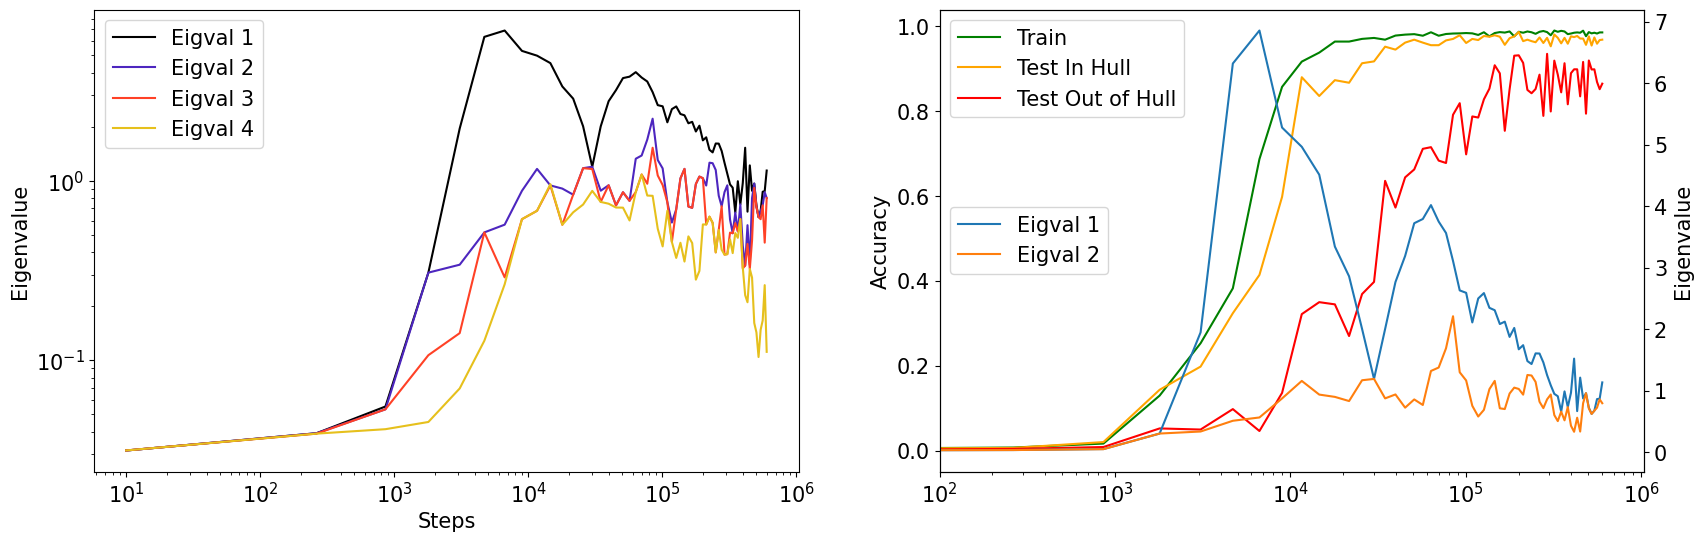

In [66]:
x_left=100
plt.figure(figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,2,1)
cmap=plt.get_cmap("CMRmap")
for i in range(4):
    plt.plot(save_steps,eigvs_abs[:,i],color=cmap(i/4),label="Eigval "+str(i+1))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
plt.xscale("log")
plt.legend()
plt.xlim(left=x_left)
plt.ylabel("Accuracy")
plt.twinx()
plt.plot(save_steps,eigvs_abs[:,0],label="Eigval 1")
plt.plot(save_steps,eigvs_abs[:,1],label="Eigval 2")
plt.legend(loc="center left")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
#plt.savefig("./figures/eigen_predict.png")

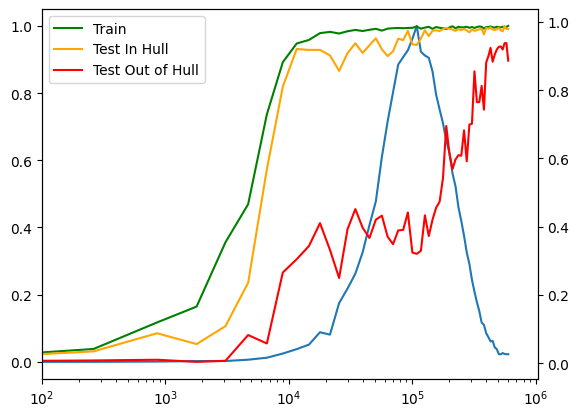

In [20]:
x_left=100
min_vlb=plot_data["min_vlb"]
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.weight'][:,:,0],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.bias'][:,:],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.2.bias'][:,:],axis=1))
plt.plot(save_steps,mMn(eigvs_abs[:,0]),label="Max. Eigval. of Cond. Proj.")
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.weight'][:,:,0],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.bias'],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.1.bias'],axis=1)))
plt.xscale("log")
plt.xlim(left=x_left)
#plt.twinx()
#plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.5)
#plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.5)
#plt.yscale("log")
plt.twinx()
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
#plt.plot(save_steps,acctr_m,c="green",ls="--")
#plt.plot(save_steps,accte_m,c="red",ls="--")
plt.legend()
